## Introduction
### Fraud detection in financial transactions is identifying and stopping fake or unauthorised activities in financial systems. It ensures customer security by monitoring transactions for unusual patterns that indicate fraud.

### Maching learning excels at analyzing massive datasets to identify unusual patterns or anomalies that may indicate fraudulent activities

## Importing packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from datetime import datetime


## Exploratory Data Analysis

### Read the data

In [2]:
data = pd.read_csv('CreditCardData.csv')

In [3]:
data.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


In [4]:
data.dtypes

Transaction ID             object
Date                       object
Day of Week                object
Time                        int64
Type of Card               object
Entry Mode                 object
Amount                     object
Type of Transaction        object
Merchant Group             object
Country of Transaction     object
Shipping Address           object
Country of Residence       object
Gender                     object
Age                       float64
Bank                       object
Fraud                       int64
dtype: object

### Data cleaning

In [5]:
data = data.dropna() # Remove missing value
data['Amount'] = data['Amount'].astype(str).str.replace('£','',regex=True).astype(float) # Remove £ and tranform it to float type

### Statisticsal value

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,99977.0,14.563100,5.308202,0.0,10.0,15.0,19.0,24.0
Amount,99977.0,112.579933,123.435613,5.0,17.0,30.0,208.0,400.0
Age,99977.0,44.993595,9.948121,15.0,38.2,44.9,51.7,86.1
Fraud,99977.0,0.071937,0.258384,0.0,0.0,0.0,0.0,1.0


### Exploratory Visualizes Fraud Rates in Different Categories

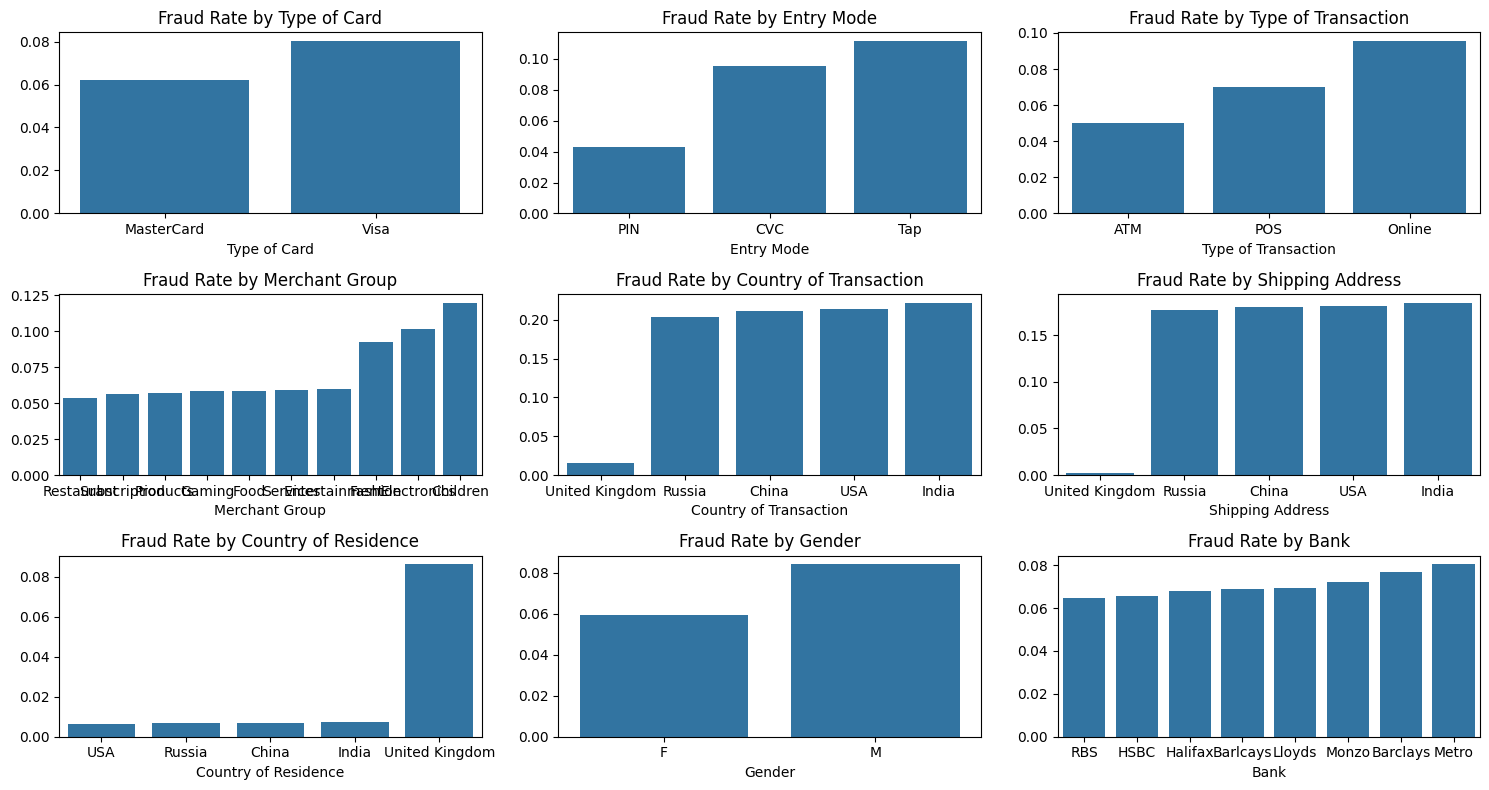

In [7]:
cat_cols = ['Type of Card','Entry Mode','Type of Transaction','Merchant Group',
            'Country of Transaction','Shipping Address','Country of Residence','Gender','Bank']

plt.figure(figsize=(15,8))

for i,col in enumerate(cat_cols):
    plt.subplot(3,3,i+1)
    fraud_rate = data.groupby(col)['Fraud'].mean().sort_values()
    sns.barplot(x=fraud_rate.index,y=fraud_rate.values)
    plt.xticks(rotation=360)
    plt.title(f"Fraud Rate by {col}")

plt.tight_layout()
plt.show()

### Time series analysis

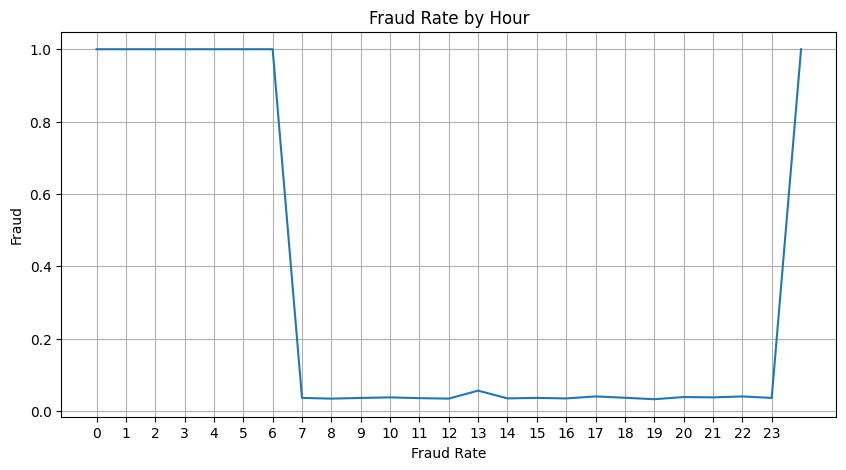

In [8]:
hourly_fraud_rate = data.groupby('Time')['Fraud'].mean()

plt.figure(figsize=(10,5))

sns.lineplot(x=hourly_fraud_rate.index,y=hourly_fraud_rate,markers="0")
plt.xticks(ticks=range(0,24),rotation=360)
plt.xlabel("Fraud Rate")
plt.title("Fraud Rate by Hour")
plt.grid()
plt.show()

### Transaction amount analysis

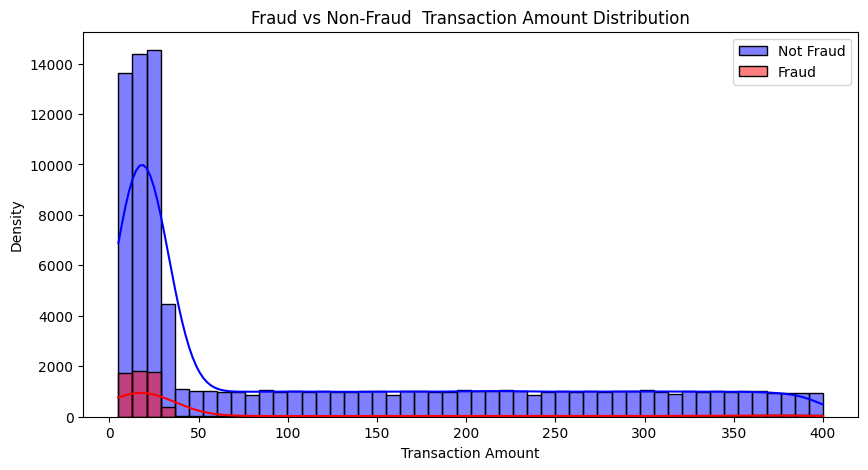

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(data[data['Fraud'] == 0]['Amount'],bins=50,color="blue",label = "Not Fraud",kde=True,alpha=0.5)
sns.histplot(data[data['Fraud'] == 1]['Amount'],bins=50,color="red",label="Fraud",kde=True,alpha=0.5)
plt.legend()
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.title("Fraud vs Non-Fraud  Transaction Amount Distribution")
plt.show()

### Variable interaction analysis

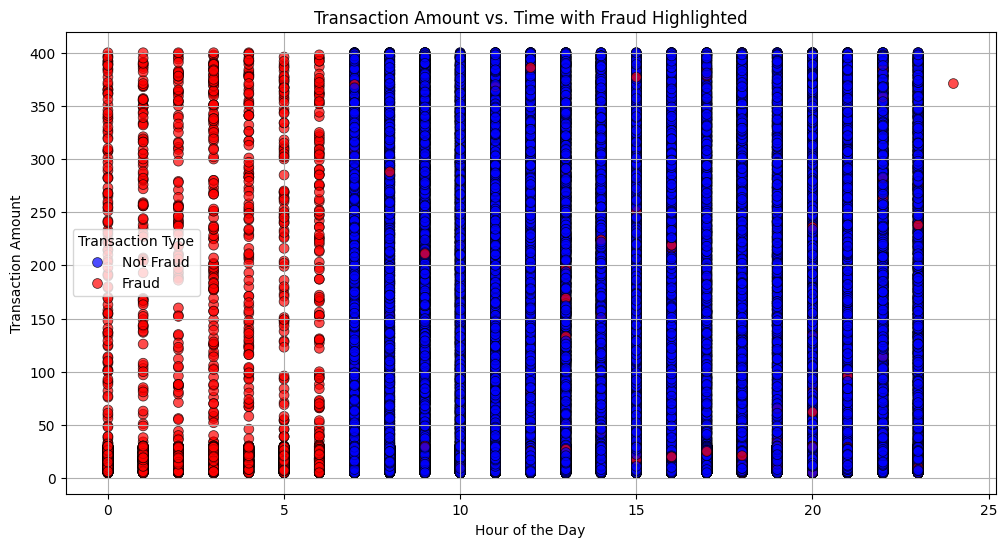

In [10]:
plt.figure(figsize=(12,6))

sns.scatterplot(
    x=data['Time'],
    y=data['Amount'],
    hue=data['Fraud'],
    palette={0:"blue",1:"Red"},
    alpha=0.7,
    edgecolor="black",
    s=50
)

plt.xlabel("Hour of the Day")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount vs. Time with Fraud Highlighted")

handels, labels = plt.gca().get_legend_handles_labels()
plt.legend(handels,["Not Fraud","Fraud"],title="Transaction Type")

plt.grid(True)
plt.show()

## Classification

### Standardize and encoding the columns

In [11]:
# Standardize 'Age' and 'Amount'
scaler = StandardScaler()
data[['Age','Amount']] = scaler.fit_transform(data[['Age','Amount']])

# Group 'Time' column into categorical bins
bins = [0,6,12,18,24]
lables = ['Late Night','Morning','Afternoon','Evening']
data['Time Category'] = pd.cut(data['Time'],bins=bins,labels=lables,right=True,include_lowest=True)

# Encode Categorical Features
categorical_cols = ['Time Category','Type of Card','Entry Mode','Type of Transaction','Merchant Group',
                    'Country of Transaction','Shipping Address','Country of Residence','Gender','Bank']

lable_ecoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    lable_ecoders[col] = le

In [12]:
data.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud,Time Category
0,#3577 209,14-Oct-20,Wednesday,19,1,2,-0.871551,2,2,4,4,4,1,-1.989692,7,0,1
1,#3039 221,14-Oct-20,Wednesday,17,0,1,1.421153,2,8,3,3,3,0,0.463045,4,0,0
2,#2694 780,14-Oct-20,Wednesday,14,1,2,-0.871551,2,7,1,1,1,0,-0.280818,0,0,0
3,#2640 960,13-Oct-20,Tuesday,14,1,2,-0.685218,2,2,4,1,4,0,0.603776,0,0,0
4,#2771 031,13-Oct-20,Tuesday,23,1,0,-0.174828,1,1,3,3,4,1,-0.703010,3,1,1


### Define Features(x) and Target(y)

In [13]:
x = data.drop(columns=['Transaction ID','Date','Day of Week','Time','Fraud']) # Features
y = data['Fraud'] # Target

### Split Data into Training and Testing Sets

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

### Handle Class Imbalance

In [15]:
somte = SMOTE(random_state=42)
x_train,y_train = somte.fit_resample(x_train,y_train)

### Choose and Train Classification Models

#### Train a Random Forest Classifier

In [16]:
# Select the best n_estimators using GridSearchCV
param_grid = {'n_estimators':[50,60,80,100]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=5)
grid_search.fit(x_train,y_train)
print("Best n_estimators:", grid_search.best_params_['n_estimators'])

Best n_estimators: 80


In [17]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=80,random_state=42)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=80, random_state=42)

#### Train an XGBoost Classifier

In [18]:
xgb = XGBClassifier(use_label_encoder = False,eval_metric = 'logloss')
xgb.fit(x_train,y_train)

e:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Model Evaluation

#### Calculate differenct scores

In [19]:
# Evaluate models using Accuracy, Precision, Recall,F1-Score and ROC-AUC
def evaluate_model(model,x_test,y_test):
    y_pred = model.predict(x_test)

    print("Accuracy",accuracy_score(y_test,y_pred))
    print("Precision",precision_score(y_test,y_pred))
    print("Recall",recall_score(y_test,y_pred))
    print("F1 Score",f1_score(y_test,y_pred))
    print("ROC-AUC Score",roc_auc_score(y_test,y_pred))

print("Random Forest Performance:")
evaluate_model(rf,x_test,y_test)

print("XGBoost Performance:")
evaluate_model(xgb,x_test,y_test)

Random Forest Performance:
Accuracy 0.9746949389877976
Precision 0.7994858611825193
Recall 0.8650904033379694
F1 Score 0.8309953239812959
ROC-AUC Score 0.9241391234277949
XGBoost Performance:
Accuracy 0.9710942188437688
Precision 0.7562574493444577
Recall 0.8824756606397774
F1 Score 0.8145057766367138
ROC-AUC Score 0.9302183239075598


#### Test whether overfiting exists

In [20]:
# Calculate Random Forest test and train score
rf_train_score = rf.score(x_train,y_train)
rf_test_score = rf.score(x_test,y_test)
rf_score_diff = rf_train_score - rf_test_score # Calculate the differences

xgb_train_score = xgb.score(x_train,y_train)
xgb_test_score = xgb.score(x_test,y_test)
xgb_score_diff = xgb_train_score - xgb_test_score # Calculate the differences

print(f"Random Forest Train Score Difference: {rf_score_diff:.4f}")

print(f"XGBoost Score Difference:{xgb_score_diff:.4f}")

Random Forest Train Score Difference: 0.0253
XGBoost Score Difference:0.0171
